# Outlook of non-CNN denoise filters
You may want to read [this](https://doi.org/10.1186/s42492-019-0016-7) recent review to understand the basics.
In <font color='red'>red</font> is my personal choice. In <font color='orange'>orange</font> - didn't try yet but should be good.



## Spatial-domain filtering
##### Normally, spatial filters eliminate noise to a reasonable extent but at the cost of image blurring, which in turn loses sharp edges.
Gaussian, Mean, Median filters, Wiener - fast but blur the image.

Bilateral filtering - the intensity value of each pixel is replaced with a weighted average of intensity values from nearby pixels. One issue concerning the bilateral filter is its efficiency. The brute-force implementation takes O(Nr2) time, which is prohibitively high when the kernel radius r is large.
Look [here](https://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html) for Python example.



## Variational denoising filters (all below)

### Total-variation regularization (TV) method
TV regularization is based on the statistical fact that natural images are locally smooth and the pixel intensity gradually varies in most regions. It has achieved great success in image denoising because it can not only effectively calculate the optimal solution but also retain sharp edges. However, it has three major drawbacks: textures tend to be over-smoothed, flat areas are approximated by a piecewise constant surface resulting in a stair-casing effect and the image suffers from losses of contrast.
Look [here](https://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html) for Python examples.


###  <font color='red'>[!]</font> Non-local means
Pointwise estimation of the image, where each pixel is obtained as a weighted average of pixels centered at regions that are similar to the region centered at the estimated pixel.  Different from local denoising methods, NLM can make full use of the information provided by the given images, which can be robust to noise. Nevertheless, structural information is not well preserved by the method, which degrades the visual image quality.

Fast but may have difficulty restoring tiny structures.
Look [here](https://scikit-image.org/docs/dev/auto_examples/filters/plot_nonlocal_means.html) for Python examples.


### Non-local centralized sparse representation (NCSR) model 
K-SVD. Sparse representation merely requires that each image patch can be represented as a linear combination of several patches from an over-complete dictionary. Good but computationally hard. 
<font color='orange'>[!]</font> NCSR produces good results.

### Low-rank minimization
The main limitation of these methods is that the rank must be provided as input, and values that are too low or too high will result in the loss of details or the preservation of noise, respectively.Although most low-rank minimization methods (especially the WNNM method) outperform previous denoising methods, the computational cost of the iterative boosting step is relatively high.
<font color='orange'>[!]</font> WNNM, LRA_SVD produce good results.

## Transform-domain filters
### Data adaptive transform
ICA, PCA - These two kinds of methods are data adaptive, and the assumptions on the difference between the image and noise still hold. However, their maindrawback is high-computational cost because they use sliding windows and require a sample of noise-free data or at least two image frames from the same scene. However, in some applications, it might be difficult to obtain noise-free training data.

### Non-adaptive, spatial-frequency domain (Fourier)
In general, after being transformed by low-pass filters, such as Fourier transform, image information mainly spreads in the low frequency domain, while noise spreads in the high frequency domain. Thus, we can remove noise by selecting specific transform domain features and transforming them back to the image domain [88]. Nevertheless, these methods are time-consuming and depend on the cut-off frequency and filter function behavior.

### Non-adaptive, wavelet domain
Wavelets can successfully remove noise while preserving the image characteristics, regardless of its frequency content. However, the wavelet transform heavily relies on the selection of wavelet bases. If the selection is inappropriate, image shown in the wavelet domain cannot be well represented, which causes poor denoising effect. Therefore, this method is not adaptive.
Look [here](https://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html) for Python examples.

### <font color='red'>[!]</font>  BM3D
The most popular denoising method. However, when the noise increases gradually, the denoising performance
of BM3D decreases greatly and artifacts are introduced, especially in flat areas.
Download Python Library [here](https://pypi.org/project/bm3d/). I have an example below.

# Some examples

In [3]:
import tifffile
import numpy as np
from maximus48 import var
import matplotlib.pyplot as plt

Text(0.5,1,'original image')

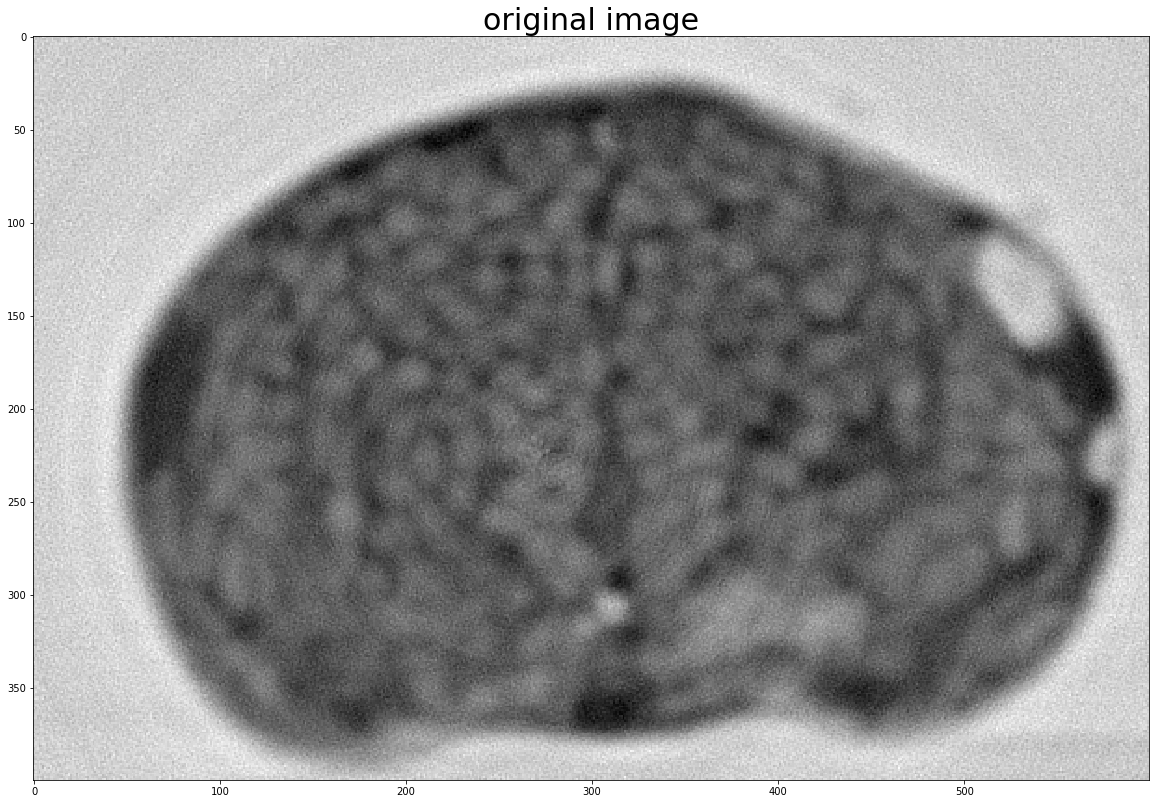

In [5]:
image = tifffile.imread('/Users/mpolikarpov/data_server/raw_data2/PROCESSED_DATA/platy1/plane_tiff/Platy-Platy_9902_tomo/tomo_01770.tiff')
var.show(image[300:700, 600:1200])
plt.title('original image', fontdict = {'fontsize' : 30})

## Bilateral filter

In [9]:
from skimage.restoration import denoise_bilateral
bilateral = denoise_bilateral(image, sigma_color=50, sigma_spatial=3, multichannel=False)

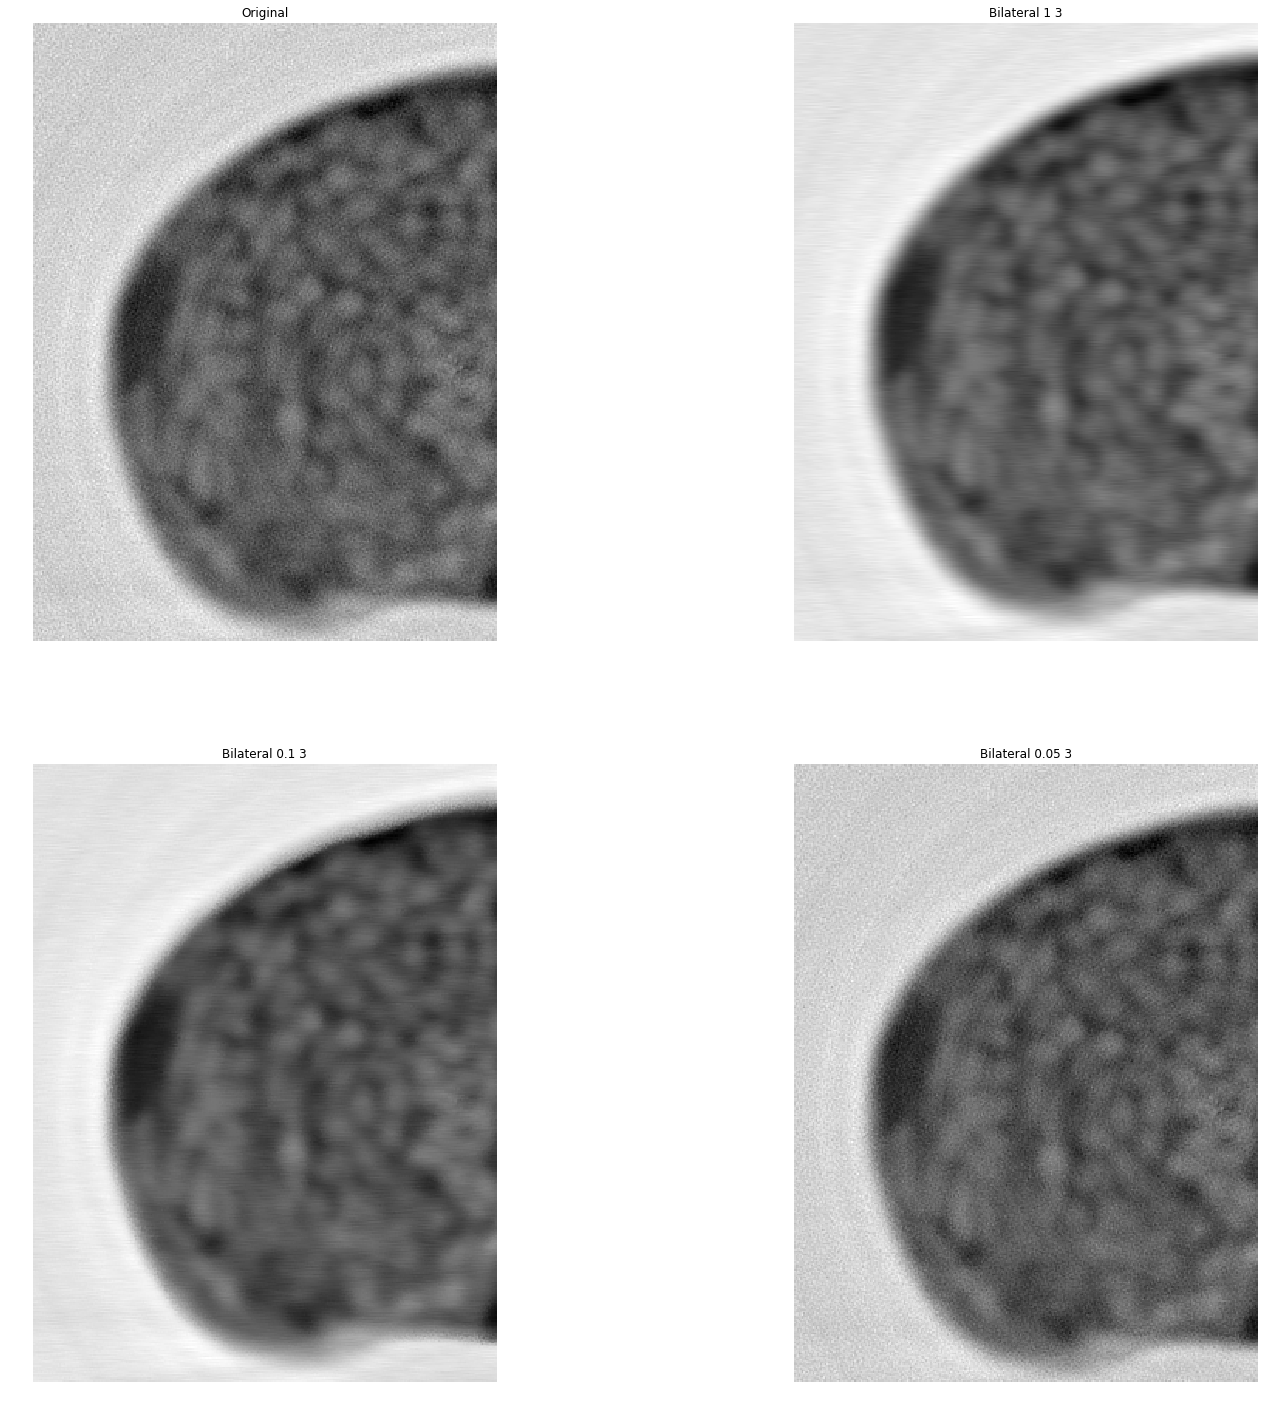

In [30]:
# show results 
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25, 25),
                       sharex=True, sharey=True)
plt.gray()
ax[0,0].imshow(image[300:700, 600:900])
ax[0,0].axis('off')
ax[0,0].set_title('Original')

ax[0,1].imshow(denoise_bilateral(image, sigma_color=1, sigma_spatial=3, multichannel=False)[300:700, 600:900])
ax[0,1].axis('off')
ax[0,1].set_title('Bilateral 1 3')

ax[1,0].imshow(denoise_bilateral(image, sigma_color=0.1, sigma_spatial=3, multichannel=False)[300:700, 600:900])
ax[1,0].axis('off')
ax[1,0].set_title('Bilateral 0.1 3')

ax[1,1].imshow(denoise_bilateral(image, sigma_color=0.01, sigma_spatial=3, multichannel=False)[300:700, 600:900])
ax[1,1].axis('off')
ax[1,1].set_title('Bilateral 0.05 3')

plt.show()

## Non-local means filter

In [1]:
from skimage.restoration import denoise_nl_means, estimate_sigma

In [6]:
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=False)

sigma_est = np.mean(estimate_sigma(image, multichannel=False))

# slow algorithm
denoise = denoise_nl_means(image, h=1.15 * sigma_est, fast_mode=False,
                           **patch_kw)

# slow algorithm, sigma provided
denoise2 = denoise_nl_means(image, h=0.8 * sigma_est, sigma=sigma_est,
                            fast_mode=False, **patch_kw)

# fast algorithm
denoise_fast = denoise_nl_means(image, h=0.8 * sigma_est, fast_mode=True,
                                **patch_kw)

# fast algorithm, sigma provided
denoise2_fast = denoise_nl_means(image, h=0.6 * sigma_est, sigma=sigma_est,
                                 fast_mode=True, **patch_kw)

print('sigma is', sigma_est)

sigma is 212.41512372786693


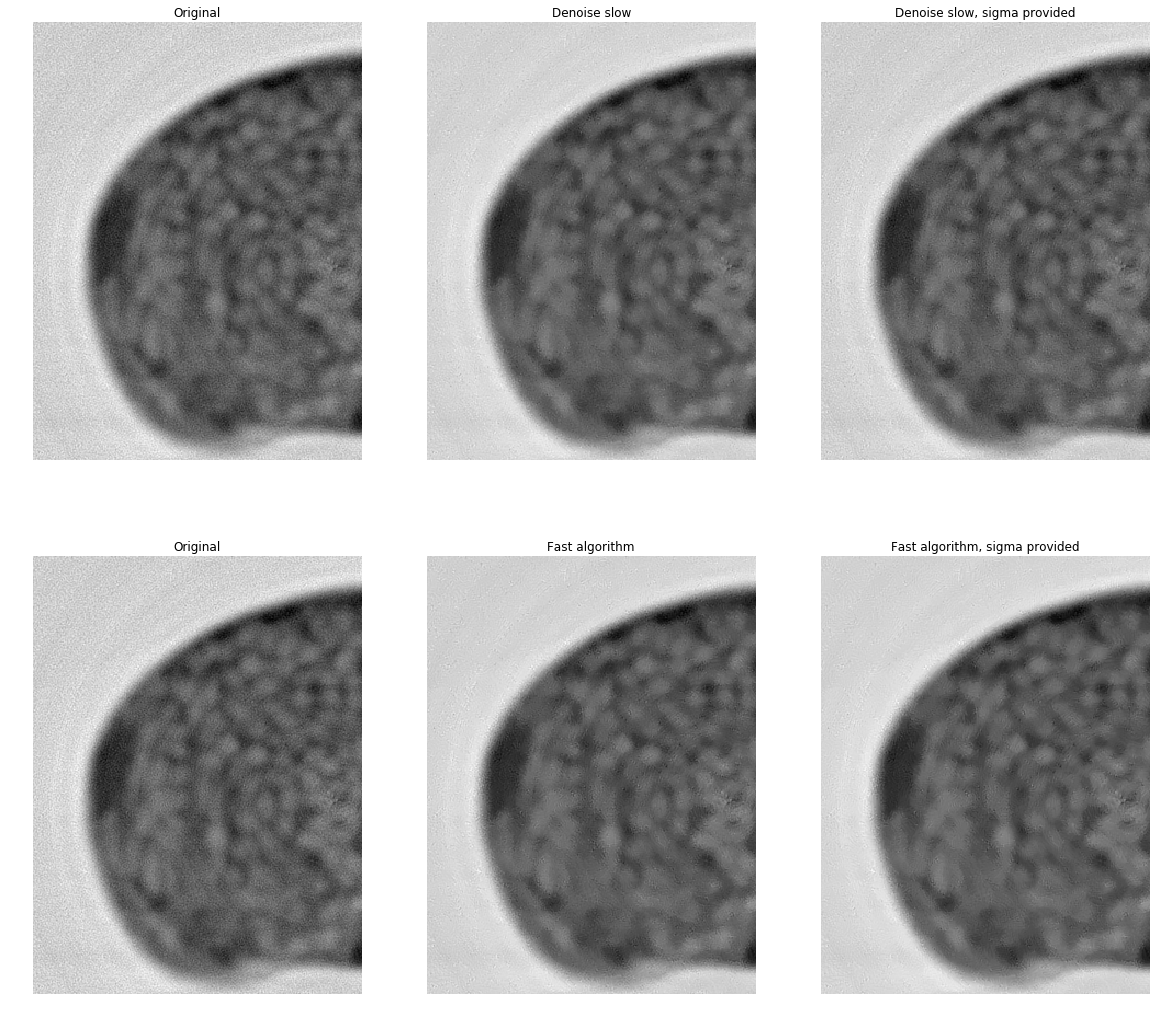

In [44]:
# show results 
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,18),
                       sharex=True, sharey=True)
plt.gray()
ax[0,0].imshow(image[300:700, 600:900])
ax[0,0].axis('off')
ax[0,0].set_title('Original')

ax[1,0].imshow(image[300:700, 600:900])
ax[1,0].axis('off')
ax[1,0].set_title('Original')

ax[0,1].imshow(denoise[300:700, 600:900])
ax[0,1].axis('off')
ax[0,1].set_title('Denoise slow')

ax[0,2].imshow(denoise2[300:700, 600:900])
ax[0,2].axis('off')
ax[0,2].set_title('Denoise slow, sigma provided')

ax[1,1].imshow(denoise_fast[300:700, 600:900])
ax[1,1].axis('off')
ax[1,1].set_title('Fast algorithm')

ax[1,2].imshow(denoise2_fast[300:700, 600:900])
ax[1,2].axis('off')
ax[1,2].set_title('Fast algorithm, sigma provided')

plt.show()

## Bilateral vs Non-local means

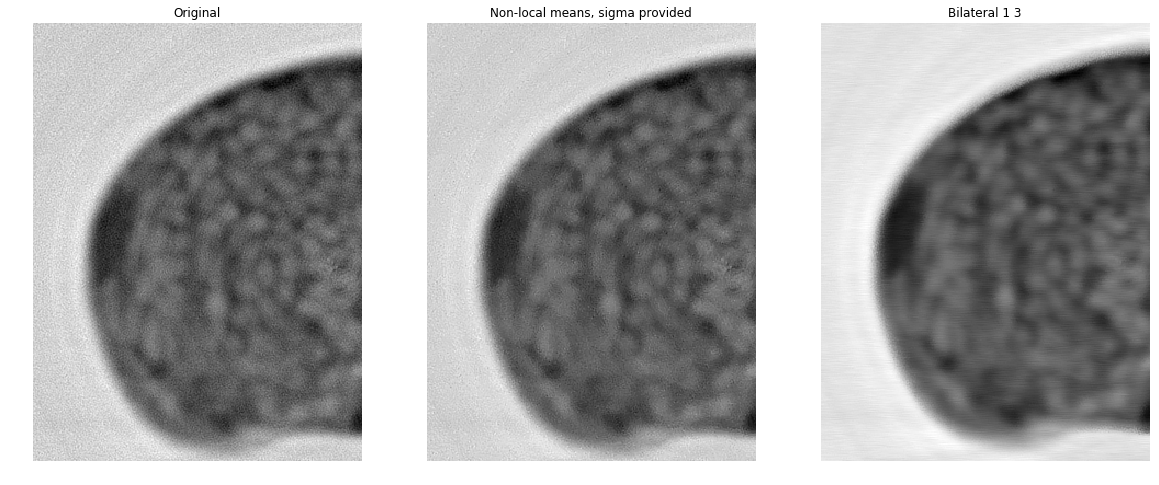

In [51]:
# show results 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,18),
                       sharex=True, sharey=True)
plt.gray()
ax[0].imshow(image[300:700, 600:900])
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(denoise_nl_means(image, h=0.8 * sigma_est, sigma=sigma_est,
                            fast_mode=False, **patch_kw)[300:700, 600:900])
ax[1].axis('off')
ax[1].set_title('Non-local means, sigma provided')

ax[2].imshow(denoise_bilateral(image, sigma_color=0.1, sigma_spatial=3, multichannel=False)[300:700, 600:900])
ax[2].axis('off')
ax[2].set_title('Bilateral 1 3')

plt.show()

## BM3D filter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR of noisy image:  58.33802328790717
PSNR of reconstructed image:  68.55407719315389


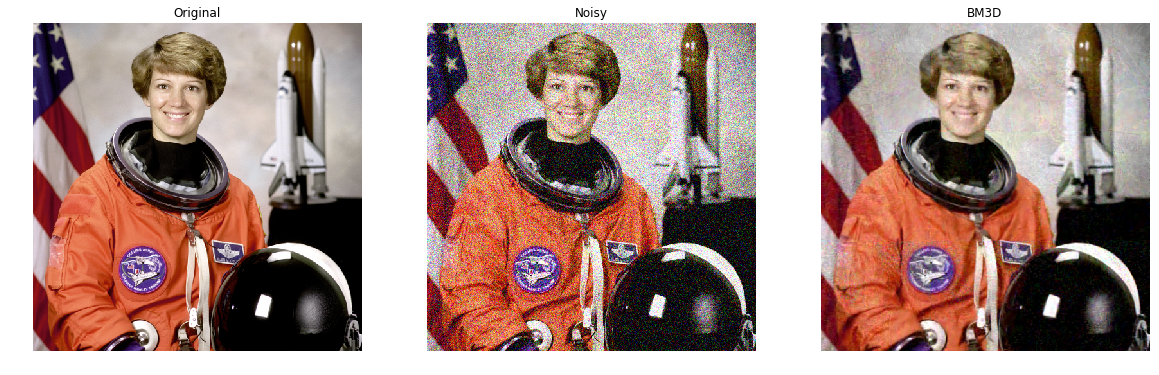

In [13]:
# basic example from here - https://github.com/ericmjonas/pybm3d

import numpy as np
import skimage.data
from skimage.measure import compare_psnr

import pybm3d


noise_std_dev = 40
img = skimage.data.astronaut().astype(np.int16)
noise = np.random.normal(scale=noise_std_dev,
                         size=img.shape).astype(img.dtype)

noisy_img = img + noise

out = pybm3d.bm3d.bm3d(noisy_img, noise_std_dev)

noise_psnr = compare_psnr(img, noisy_img)
out_psnr = compare_psnr(img, out)

print("PSNR of noisy image: ", noise_psnr)
print("PSNR of reconstructed image: ", out_psnr)


# show results 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,18),
                       sharex=True, sharey=True)
#plt.gray()
ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(noisy_img)
ax[1].axis('off')
ax[1].set_title('Noisy')

ax[2].imshow(out)
ax[2].axis('off')
ax[2].set_title('BM3D')
plt.show()


PSNR of reconstructed image 2:  84.31095623228435
PSNR of reconstructed image 3:  56.99863268905859
PSNR of reconstructed image 4:  48.098058890226866


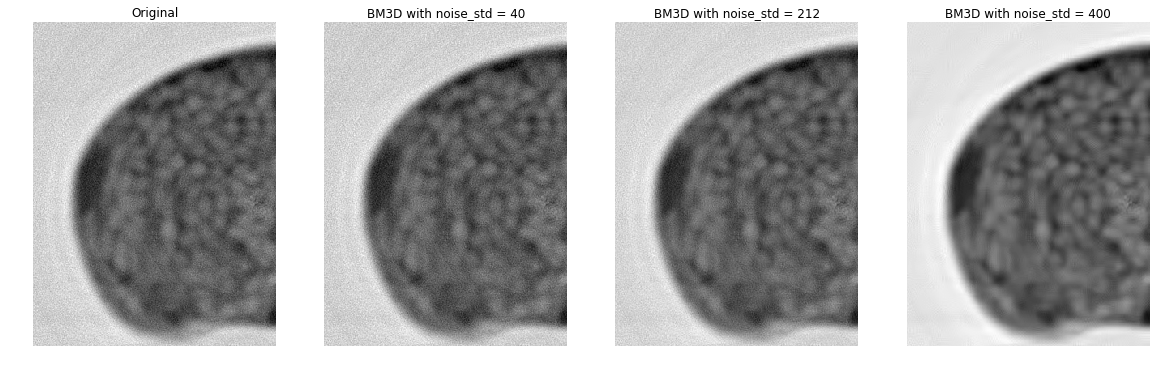

In [53]:
# my example
import pybm3d
from skimage.restoration import estimate_sigma

#didn't try this repo but it should also work
#import bm3d


noisy = image[300:700, 600:900]

noise_std_dev = 40
out1 = pybm3d.bm3d.bm3d(noisy, noise_std_dev)
out_psnr1 = compare_psnr(noisy, out1)
print("PSNR of reconstructed image 2: ", out_psnr1)

sigma_est = np.mean(estimate_sigma(image, multichannel=False))
out2 = pybm3d.bm3d.bm3d(noisy, sigma_est)
out_psnr2 = compare_psnr(noisy, out2)
print("PSNR of reconstructed image 3: ", out_psnr2)

out3 = pybm3d.bm3d.bm3d(noisy, 400)
out_psnr3 = compare_psnr(noisy, out3)
print("PSNR of reconstructed image 4: ", out_psnr3)

# show results 
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,18),
                       sharex=True, sharey=True)
#plt.gray()
ax[0].imshow(noisy)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(out1)
ax[1].axis('off')
ax[1].set_title('BM3D with noise_std = ' + str(int(noise_std_dev)))

ax[2].imshow(out2)
ax[2].axis('off')
ax[2].set_title('BM3D with noise_std = ' + str(int(sigma_est)))

ax[3].imshow(out3)
ax[3].axis('off')
ax[3].set_title('BM3D with noise_std = 400')

plt.show()

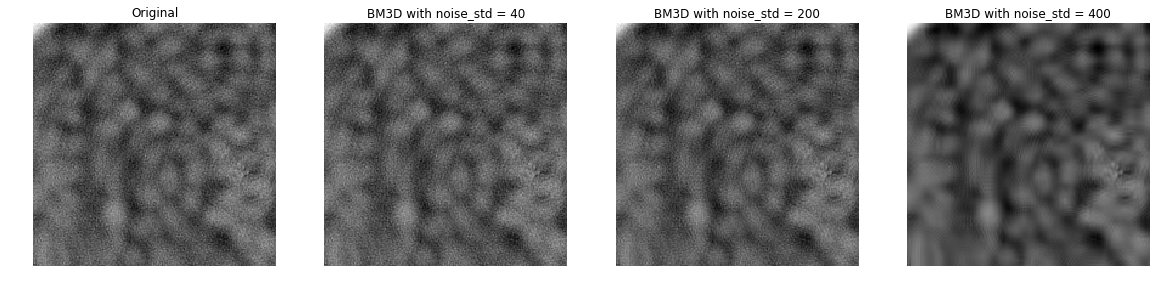

In [51]:
# show results 
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,18),
                       sharex=True, sharey=True)

ax[0].imshow(noisy[100:300, 100:300])
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(pybm3d.bm3d.bm3d(noisy[100:300, 100:300], 40))
ax[1].axis('off')
ax[1].set_title('BM3D with noise_std = 40')

ax[2].imshow(pybm3d.bm3d.bm3d(noisy[100:300, 100:300], 200))
ax[2].axis('off')
ax[2].set_title('BM3D with noise_std = 200')

ax[3].imshow(pybm3d.bm3d.bm3d(noisy[100:300, 100:300], 400))
ax[3].axis('off')
ax[3].set_title('BM3D with noise_std = 400')

plt.show()

# BM3D vs Non-local means

PSNR of reconstructed image NLM:  57.055762377425275
PSNR of reconstructed image NLM_400:  57.055762377425275
PSNR of reconstructed image BM3D:  84.31095623228435
PSNR of reconstructed image BM3D_400:  48.098058890226866


/Users/mpolikarpov/anaconda3/envs/tomography/lib/python3.5/site-packages/skimage/measure/simple_metrics.py:127: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


Text(0.5,1,'BM3D with noise_std = 400')

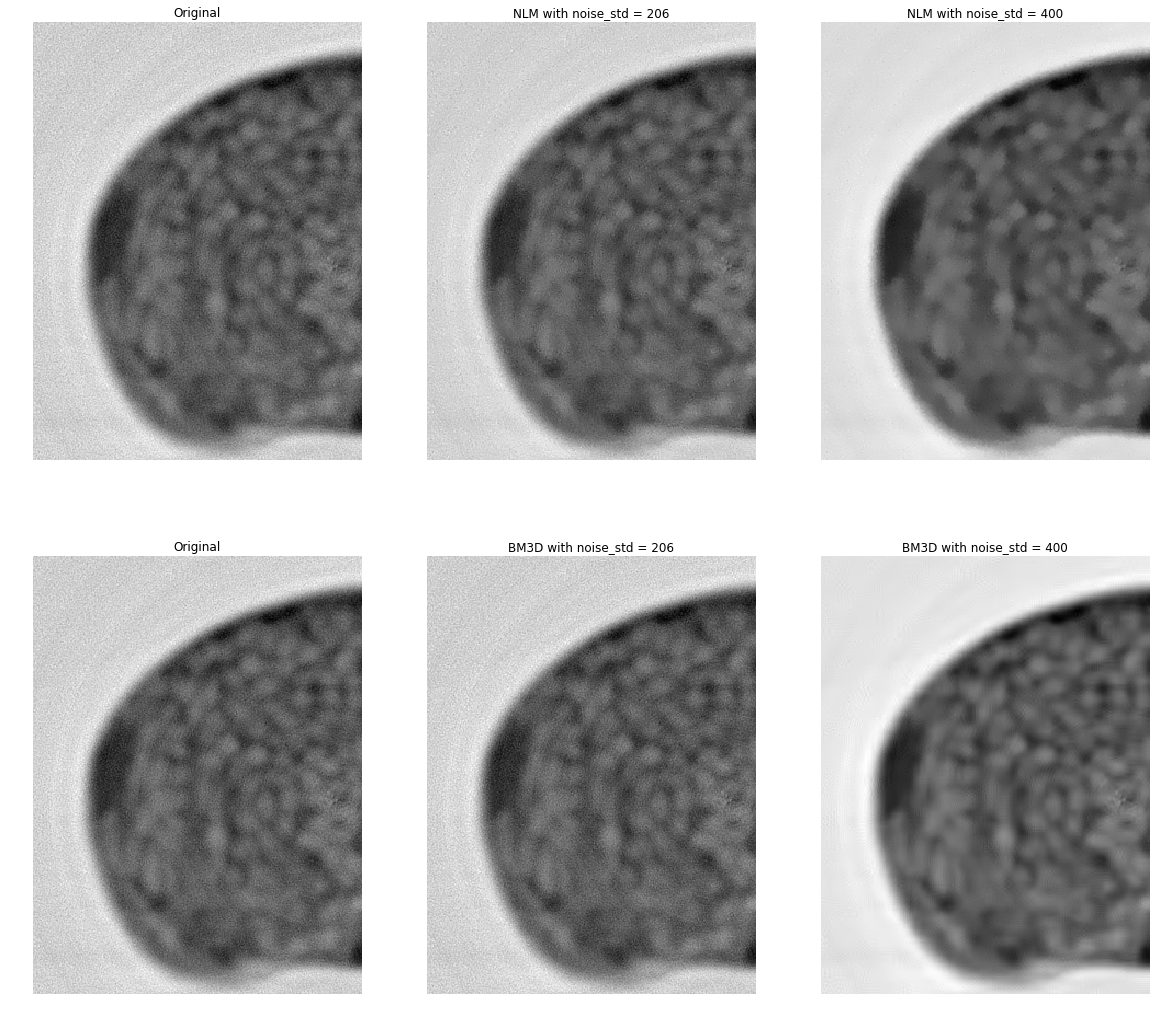

In [65]:
import pybm3d
from skimage.restoration import denoise_nl_means, estimate_sigma


noisy = image[300:700, 600:900]
sigma_est = np.mean(estimate_sigma(noisy, multichannel=False))

NLM = denoise_nl_means(noisy, h=0.8 * sigma_est, sigma=sigma_est,
                            fast_mode=False, **patch_kw)
BM3D = pybm3d.bm3d.bm3d(noisy, noise_std_dev)
NLM_400 = denoise_nl_means(noisy, h=0.8 * 400, sigma=400,
                            fast_mode=False, **patch_kw)
BM3D_400 = pybm3d.bm3d.bm3d(noisy, 400)

out_psnr_NLM = compare_psnr(noisy, NLM)
out_psnr_NLM_400 = compare_psnr(noisy, NLM)
out_psnr_BM3D = compare_psnr(noisy, BM3D)
out_psnr_BM3D_400 = compare_psnr(noisy, BM3D_400)
print("PSNR of reconstructed image NLM: ", out_psnr_NLM)
print("PSNR of reconstructed image NLM_400: ", out_psnr_NLM_400)
print("PSNR of reconstructed image BM3D: ", out_psnr_BM3D)
print("PSNR of reconstructed image BM3D_400: ", out_psnr_BM3D_400)

# show results 
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,18),
                       sharex=True, sharey=True)
ax[0,0].imshow(noisy)
ax[0,0].axis('off')
ax[0,0].set_title('Original')

ax[0,1].imshow(NLM)
ax[0,1].axis('off')
ax[0,1].set_title('NLM with noise_std = ' + str(int(sigma_est)))

ax[0,2].imshow(NLM_400)
ax[0,2].axis('off')
ax[0,2].set_title('NLM with noise_std = 400')

ax[1,0].imshow(noisy)
ax[1,0].axis('off')
ax[1,0].set_title('Original')

ax[1,1].imshow(BM3D)
ax[1,1].axis('off')
ax[1,1].set_title('BM3D with noise_std = ' + str(int(sigma_est)))

ax[1,2].imshow(BM3D_400)
ax[1,2].axis('off')
ax[1,2].set_title('BM3D with noise_std = 400')

Text(0.5,1,'BM3D with noise_std = 400')

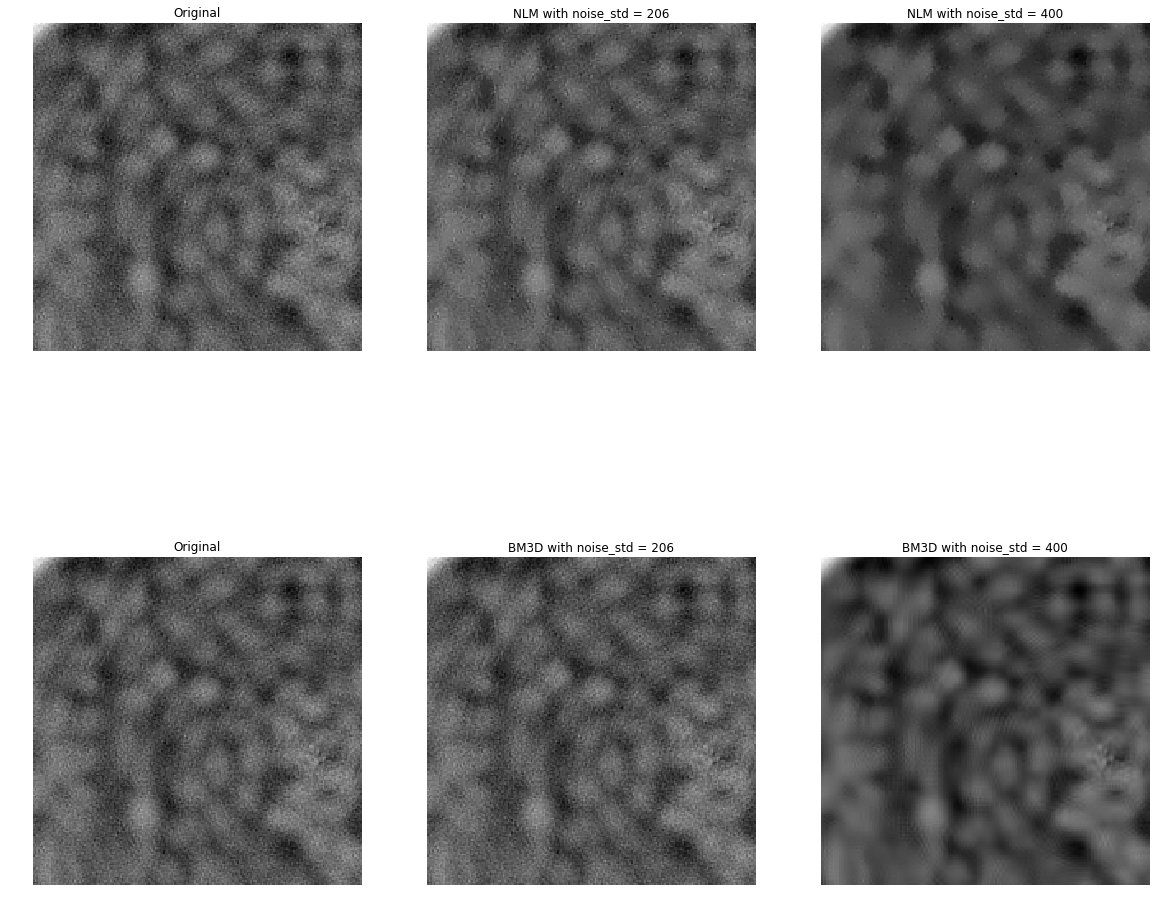

In [66]:
# show results 
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,18),
                       sharex=True, sharey=True)
ax[0,0].imshow(noisy[100:300, 100:300])
ax[0,0].axis('off')
ax[0,0].set_title('Original')

ax[0,1].imshow(NLM[100:300, 100:300])
ax[0,1].axis('off')
ax[0,1].set_title('NLM with noise_std = ' + str(int(sigma_est)))

ax[0,2].imshow(NLM_400[100:300, 100:300])
ax[0,2].axis('off')
ax[0,2].set_title('NLM with noise_std = 400')

ax[1,0].imshow(noisy[100:300, 100:300])
ax[1,0].axis('off')
ax[1,0].set_title('Original')

ax[1,1].imshow(BM3D[100:300, 100:300])
ax[1,1].axis('off')
ax[1,1].set_title('BM3D with noise_std = ' + str(int(sigma_est)))

ax[1,2].imshow(BM3D_400[100:300, 100:300])
ax[1,2].axis('off')
ax[1,2].set_title('BM3D with noise_std = 400')